In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Importar Bibliotecas e dados


In [85]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.base import clone

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [86]:
dataset_path = '/content/drive/My Drive/dataset_mc853/train_data.csv'
train_data = pd.read_csv(dataset_path, index_col=0)

dataset_path = '/content/drive/My Drive/dataset_mc853/test_data.csv'
test_data = pd.read_csv(dataset_path, index_col=0)

In [87]:
model_path = '/content/drive/My Drive/dataset_mc853/best_model.pkl'
# importar modelo
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# Explorar métrica de fairness

In [161]:
all_models_results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1'])

In [162]:
test_data["EVOLUCAO"].value_counts()

,count
EVOLUCAO,
0,473
1,154


In [163]:
pred = model.predict(test_data.drop(["EVOLUCAO"], axis=1))

accuracy = balanced_accuracy_score(test_data["EVOLUCAO"], pred)
precision = precision_score(test_data["EVOLUCAO"], pred)
recall = recall_score(test_data["EVOLUCAO"], pred)
f1 = f1_score(test_data["EVOLUCAO"], pred)

all_models_results = pd.concat([
    all_models_results,
    pd.DataFrame({
        'model': ['Antes do Oversampling'],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1]
    })
], ignore_index=True)


<ipython-input-163-484383310>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_models_results = pd.concat([


In [164]:
# escolhemos a coluna sexo pra medir o fairness

# selecionar instancias de mulheres
df_test_female = test_data[test_data['CS_SEXO'] == 0]

# selecionar instancias de homens
df_test_male = test_data[test_data['CS_SEXO'] == 1]

# testar modelo nas instancias femininas
y_pred_female = model.predict(df_test_female.drop(['EVOLUCAO'], axis=1))

# testar modelo nas instancias masculinas
y_pred_male = model.predict(df_test_male.drop(['EVOLUCAO'], axis=1))

# checar recall para mulheres e recall para homens
recall_score_female = recall_score(df_test_female['EVOLUCAO'], y_pred_female)
recall_score_male = recall_score(df_test_male['EVOLUCAO'], y_pred_male)
precision_score_female = precision_score(df_test_female['EVOLUCAO'], y_pred_female)
precision_score_male = precision_score(df_test_male['EVOLUCAO'], y_pred_male)

# Análise investigativa dos resultados

In [165]:
# é curioso notar que o modelo performa melhor para mulheres na métrica recall, apesar de haver menos mulheres
test_data['CS_SEXO'].value_counts()

,count
CS_SEXO,
1,477
0,150


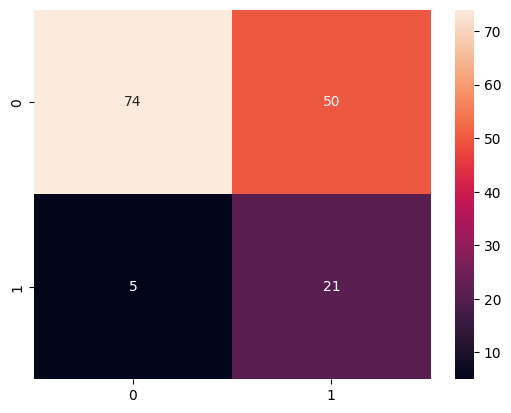

In [166]:
#plotar matriz de confusão para mulheres
cm_fem_pre_fairness = confusion_matrix(df_test_female['EVOLUCAO'], y_pred_female)
sns.heatmap(cm_fem_pre_fairness, annot=True, fmt='d')
plt.show()

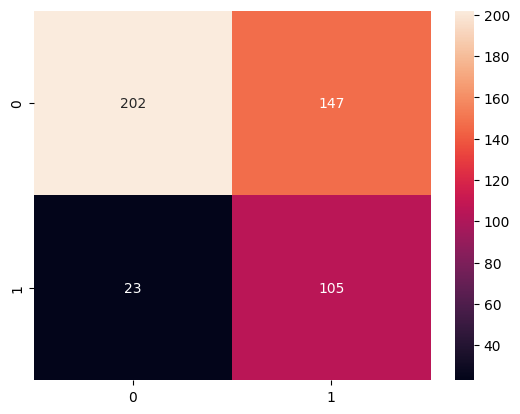

In [167]:
#plotar matriz de confusão para homens
cm_men_pre_fairness = confusion_matrix(df_test_male['EVOLUCAO'], y_pred_male)
sns.heatmap(cm_men_pre_fairness, annot=True, fmt='d')
plt.show()

In [168]:
results_pre_fairness = pd.DataFrame()
false_positives_fem_pre_fairness = cm_fem_pre_fairness[0][1] / (cm_fem_pre_fairness[0][0] + cm_fem_pre_fairness[0][1])
positive_predictions_fem_pre_fairness = (cm_fem_pre_fairness[0][1] + cm_fem_pre_fairness[1][1]) / cm_fem_pre_fairness.sum()
false_positives_men_pre_fairness = cm_men_pre_fairness[0][1] / (cm_men_pre_fairness[0][0] + cm_men_pre_fairness[0][1])
positive_predictions_men_pre_fairness = (cm_men_pre_fairness[0][1] + cm_men_pre_fairness[1][1]) / cm_men_pre_fairness.sum()

In [169]:
results_pre_fairness['grupo'] = ['mulheres', 'homens']
results_pre_fairness['precision'] = [precision_score_female, precision_score_male]
results_pre_fairness['recall'] = [recall_score_female, recall_score_male]
results_pre_fairness['taxa de falsos positivos'] = [false_positives_fem_pre_fairness, false_positives_men_pre_fairness]
results_pre_fairness['predicoes positivas'] = [positive_predictions_fem_pre_fairness, positive_predictions_men_pre_fairness]

In [170]:
results_pre_fairness

,grupo,precision,recall,taxa de falsos positivos,predicoes positivas
0,mulheres,0.295775,0.807692,0.403226,0.473333
1,homens,0.416667,0.820312,0.421203,0.528302


# Estratégia para fairness


In [171]:

def balance(X, y):
    """
    Balancear classes para que fiquem na proporção 1.5:1
    """
    #encontrar classe majoritária
    majoritaria = y.value_counts().idxmax()
    minoritaria = y.value_counts().idxmin()

    #checar se as classes obedecem uma proporção de 1.5:1
    prop = y.value_counts()[majoritaria]/y.value_counts()[minoritaria]
    if (prop) <= 1.5:
        return X, y
    else:
        #calcular proporções
        prop_min = y.value_counts()[minoritaria]/y.value_counts()[majoritaria]

        #aumentar minoritaria em 20%
        prop_min = prop_min *1.2

        #aumentar a minoritaria
        oversample = SMOTE(sampling_strategy=prop_min)
        X, y = oversample.fit_resample(X, y)

        #retirar da majoritaria até que a minoritária seja 67% do total
        #com isso a minoritaria sera 40% do total e  a majoritaria sera 60%
        undersample = NearMiss(sampling_strategy=0.67)
        X, y = undersample.fit_resample(X, y)

        return X, y


## Over/Under Sampling 0.5

In [172]:
train_data["CS_SEXO"].value_counts()

,count
CS_SEXO,
1,756
0,239


In [173]:
# selecionar instâncias de mulheres
df_train_female = train_data[train_data['CS_SEXO'] == 0]

# aumentar dados de mulheres
oversample = SMOTE(sampling_strategy=0.5)
X_train, y_train = oversample.fit_resample(train_data.drop(['CS_SEXO'], axis=1), train_data['CS_SEXO'])

# copiar dados
X_train["CS_SEXO"] = y_train
over_train_data = X_train.copy()

In [174]:
over_train_data["CS_SEXO"].value_counts()

,count
CS_SEXO,
1,756
0,378


In [175]:
#definir classificadores
classifiers_05 = {
              'KNN': KNeighborsClassifier(),
              'Random Forest': RandomForestClassifier(),
              'Logistic Regression': LogisticRegression()
              }
#parâmetros para grid search
knn_params = {'n_neighbors': [1, 5, 10],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

lr_params = {'class_weight': ['balanced',
                              {0: 1, 1: 2},
                              {0: 1, 1: 3}]
             }

rf_params = {
             'n_estimators': [10,100,200],
             'max_depth': [10,50],
             'min_samples_split': [2,10,30]
             }


parameters =  {'KNN': knn_params,
               'Random Forest': rf_params,
               'Logistic Regression': lr_params
               }

In [176]:
clf_score = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall'])
models_05 = {
    'KNN': [],
    'Random Forest': [],
    'Logistic Regression': []
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name in classifiers_05.keys():
    clf = classifiers_05[clf_name]
    params = parameters[clf_name]
    fold_score = {}

    print(clf_name)
    for i, (train, test) in tqdm(enumerate(kf.split(over_train_data.drop('EVOLUCAO', axis=1), over_train_data['EVOLUCAO']))):

        grid = GridSearchCV(
                          estimator=clone(clf),
                          param_grid=params,
                          scoring={"balanced_accuracy":"balanced_accuracy",
                                   "precision":"precision",
                                   "recall":"recall",
                                   "f1":"f1"},
                          refit="f1",
                          cv=5,
                          )

        # dividir em treino e teste
        X_train, X_test = over_train_data.drop('EVOLUCAO', axis=1).iloc[train], over_train_data.drop('EVOLUCAO', axis=1).iloc[test]
        y_train, y_test = over_train_data['EVOLUCAO'].iloc[train], over_train_data['EVOLUCAO'].iloc[test]

        # balancear treino
        X_train, y_train = balance(X_train, y_train)

        # treinar
        best_model = grid.fit(X_train, y_train)

        # testar
        predictions = best_model.predict(X_test)

        # calcular métricas
        fold_score['model'] = f"{clf_name}_{i}"
        fold_score['accuracy'] = balanced_accuracy_score(y_test, predictions)
        fold_score['precision'] = precision_score(y_test, predictions)
        fold_score['recall'] = recall_score(y_test, predictions)
        fold_score['f1'] = f1_score(y_test, predictions)

        # salvar métricas
        fold_score = pd.DataFrame(fold_score, index=[0])
        clf_score = pd.concat([clf_score,fold_score], ignore_index=True)

        # salvar modelo
        models_05[clf_name].append(best_model)

KNN


0it [00:00, ?it/s]<ipython-input-176-798352540>:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clf_score = pd.concat([clf_score,fold_score], ignore_index=True)
5it [00:06,  1.21s/it]


Random Forest


5it [01:36, 19.32s/it]


Logistic Regression


5it [00:03,  1.33it/s]


In [177]:
# clf_score

In [178]:
over_test_data = test_data.copy()
#change columns order
over_test_data = over_test_data[over_train_data.columns]

In [179]:
best_model = models_05['Logistic Regression'][3]

predictions = best_model.predict(over_test_data.drop('EVOLUCAO', axis=1))

accuracy = balanced_accuracy_score(over_test_data['EVOLUCAO'], predictions)
precision = precision_score(over_test_data['EVOLUCAO'], predictions)
recall = recall_score(over_test_data['EVOLUCAO'], predictions)
f1 = f1_score(over_test_data['EVOLUCAO'], predictions)

all_models_results = pd.concat([
    all_models_results,
    pd.DataFrame({
        'model': ['Oversampling 0.5'],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1]
    })]
)

In [180]:
best_model.best_estimator_

LogisticRegression(class_weight='balanced')

In [181]:
# escolhemos a coluna sexo pra medir o fairness

# selecionar instancias de mulheres
df_test_female = over_test_data[over_test_data['CS_SEXO'] == 0]

# selecionar instancias de homens
df_test_male = over_test_data[over_test_data['CS_SEXO'] == 1]

# testar modelo nas instancias femininas
y_pred_female = best_model.predict(df_test_female.drop(['EVOLUCAO'], axis=1))

# testar modelo nas instancias masculinas
y_pred_male = best_model.predict(df_test_male.drop(['EVOLUCAO'], axis=1))

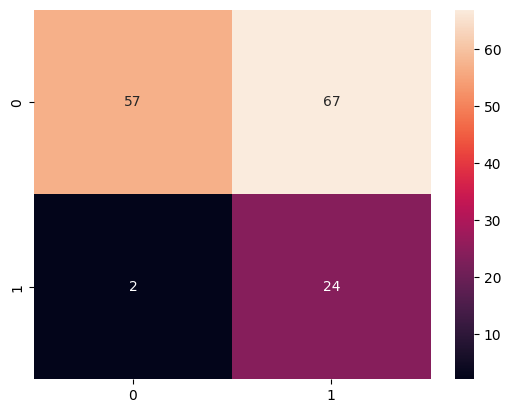

In [182]:
#plotar matriz de confusão para mulheres
cm_fem_05 = confusion_matrix(df_test_female['EVOLUCAO'], y_pred_female)
sns.heatmap(cm_fem_05, annot=True, fmt='d')
plt.show()

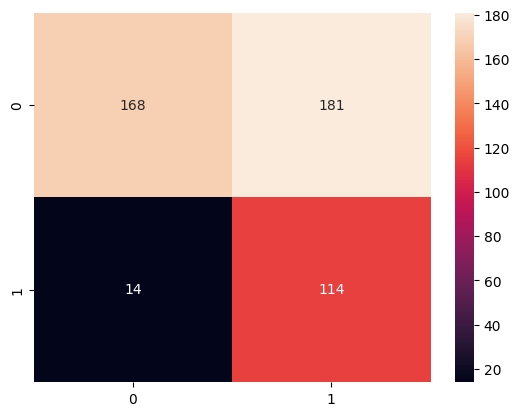

In [183]:
#plotar matriz de confusão para homens
cm_men_05 = confusion_matrix(df_test_male['EVOLUCAO'], y_pred_male)
sns.heatmap(cm_men_05, annot=True, fmt='d')
plt.show()

In [184]:
#extrair metricas
false_positives_fem = cm_fem_05[0][1] / (cm_fem_05[0][0] + cm_fem_05[0][1])
positive_predictions_fem = (cm_fem_05[0][1] + cm_fem_05[1][1]) / cm_fem_05.sum()
recall_score_female = recall_score(df_test_female['EVOLUCAO'], y_pred_female)
precision_score_female = precision_score(df_test_female['EVOLUCAO'], y_pred_female)

positive_predictions_men = (cm_men_05[0][1] + cm_men_05[1][1]) / cm_men_05.sum()
recall_score_male = recall_score(df_test_male['EVOLUCAO'], y_pred_male)
false_positives_men = cm_men_05[0][1] / (cm_men_05[0][0] + cm_men_05[0][1])
precision_score_male = precision_score(df_test_male['EVOLUCAO'], y_pred_male)

In [185]:
results_05 = pd.DataFrame()
results_05['grupo'] = ['mulheres', 'homens']
results_05['recall'] = [recall_score_female, recall_score_male]
results_05['precision'] = [precision_score_female, precision_score_male]
results_05['taxa de falsos positivos'] = [false_positives_fem, false_positives_men]
results_05['predicoes positivas'] = [positive_predictions_fem, positive_predictions_men]

In [186]:
results_05

,grupo,recall,precision,taxa de falsos positivos,predicoes positivas
0,mulheres,0.923077,0.263736,0.540323,0.606667
1,homens,0.890625,0.386441,0.518625,0.618449


## Over/Under Sampling 0.75

In [187]:
train_data["CS_SEXO"].value_counts()

,count
CS_SEXO,
1,756
0,239


In [188]:
# selecionar instâncias de mulheres
df_train_female = train_data[train_data['CS_SEXO'] == 0]

# aumentar dados de mulheres
oversample = SMOTE(sampling_strategy=0.75)
X_train, y_train = oversample.fit_resample(train_data.drop(['CS_SEXO'], axis=1), train_data['CS_SEXO'])

# copiar dados
X_train["CS_SEXO"] = y_train
over_train_data = X_train.copy()

In [189]:
over_train_data["CS_SEXO"].value_counts()

,count
CS_SEXO,
1,756
0,567


In [190]:
#definir classificadores
classifiers_75 = {
              'KNN': KNeighborsClassifier(),
              'Random Forest': RandomForestClassifier(),
              'Logistic Regression': LogisticRegression()
              }
#parâmetros para grid search
knn_params = {'n_neighbors': [1, 5, 10],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

lr_params = {'class_weight': ['balanced',
                              {0: 1, 1: 2},
                              {0: 1, 1: 3}]
             }

rf_params = {
             'n_estimators': [10,100,200],
             'max_depth': [10,50],
             'min_samples_split': [2,10,30]
             }


parameters =  {'KNN': knn_params,
               'Random Forest': rf_params,
               'Logistic Regression': lr_params
               }

In [191]:
clf_score = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall'])
models_75 = {
    'KNN': [],
    'Random Forest': [],
    'Logistic Regression': []
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name in classifiers_75.keys():
    clf = classifiers_75[clf_name]
    params = parameters[clf_name]
    fold_score = {}

    print(clf_name)
    for i, (train, test) in tqdm(enumerate(kf.split(over_train_data.drop('EVOLUCAO', axis=1), over_train_data['EVOLUCAO']))):

        grid = GridSearchCV(
                          estimator=clone(clf),
                          param_grid=params,
                          scoring={"balanced_accuracy":"balanced_accuracy",
                                   "precision":"precision",
                                   "recall":"recall",
                                   "f1":"f1"},
                          refit="f1",
                          cv=5,
                          )

        # dividir em treino e teste
        X_train, X_test = over_train_data.drop('EVOLUCAO', axis=1).iloc[train], over_train_data.drop('EVOLUCAO', axis=1).iloc[test]
        y_train, y_test = over_train_data['EVOLUCAO'].iloc[train], over_train_data['EVOLUCAO'].iloc[test]

        # balancear treino
        X_train, y_train = balance(X_train, y_train)

        # treinar
        best_model = grid.fit(X_train, y_train)

        # testar
        predictions = best_model.predict(X_test)

        # calcular métricas
        fold_score['model'] = f"{clf_name}_{i}"
        fold_score['accuracy'] = balanced_accuracy_score(y_test, predictions)
        fold_score['precision'] = precision_score(y_test, predictions)
        fold_score['recall'] = recall_score(y_test, predictions)
        fold_score['f1'] = f1_score(y_test, predictions)

        # salvar métricas
        fold_score = pd.DataFrame(fold_score, index=[0])
        clf_score = pd.concat([clf_score,fold_score], ignore_index=True)

        # salvar modelo
        models_75[clf_name].append(best_model)

KNN


0it [00:00, ?it/s]<ipython-input-191-3782417380>:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clf_score = pd.concat([clf_score,fold_score], ignore_index=True)
5it [00:05,  1.14s/it]


Random Forest


5it [01:35, 19.14s/it]


Logistic Regression


5it [00:01,  2.56it/s]


In [192]:
# clf_score

In [193]:
over_test_data = test_data.copy()
#change columns order
over_test_data = over_test_data[over_train_data.columns]
# check
over_test_data.columns

Index(['NU_IDADE_N', 'CLI_FEBRE', 'CLI_MIALGI', 'CLI_CEFALE', 'CLI_PROST',
       'CLI_CONGES', 'CLI_VOMITO', 'CLI_DIARRE', 'CLI_ICTERI', 'CLI_RENAL',
       'CLI_RESPIR', 'CLI_CARDIA', 'CLI_MENING', 'EVOLUCAO',
       'regiao_Centro_Oeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul',
       'regiao_Nordeste', 'CS_SEXO'],
      dtype='object')

In [194]:
best_model = models_75['Logistic Regression'][3]

predictions = best_model.predict(over_test_data.drop('EVOLUCAO', axis=1))

accuracy = balanced_accuracy_score(over_test_data['EVOLUCAO'], predictions)
precision = precision_score(over_test_data['EVOLUCAO'], predictions)
recall = recall_score(over_test_data['EVOLUCAO'], predictions)
f1 = f1_score(over_test_data['EVOLUCAO'], predictions)

all_models_results = pd.concat([
    all_models_results,
    pd.DataFrame({
        'model': ['Oversampling 0.75'],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1]
    })]
)

In [195]:
best_model.best_estimator_

LogisticRegression(class_weight='balanced')

In [196]:
# escolhemos a coluna sexo pra medir o fairness

# selecionar instancias de mulheres
df_test_female = over_test_data[over_test_data['CS_SEXO'] == 0]

# selecionar instancias de homens
df_test_male = over_test_data[over_test_data['CS_SEXO'] == 1]

# testar modelo nas instancias femininas
y_pred_female = best_model.predict(df_test_female.drop(['EVOLUCAO'], axis=1))

# testar modelo nas instancias masculinas
y_pred_male = best_model.predict(df_test_male.drop(['EVOLUCAO'], axis=1))

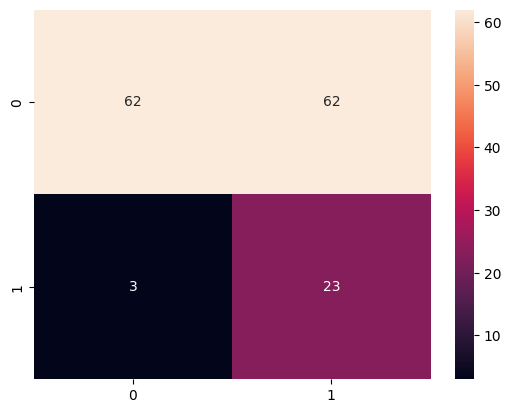

In [197]:
#plotar matriz de confusão para mulheres
cm_fem_75 = confusion_matrix(df_test_female['EVOLUCAO'], y_pred_female)
sns.heatmap(cm_fem_75, annot=True, fmt='d')
plt.show()

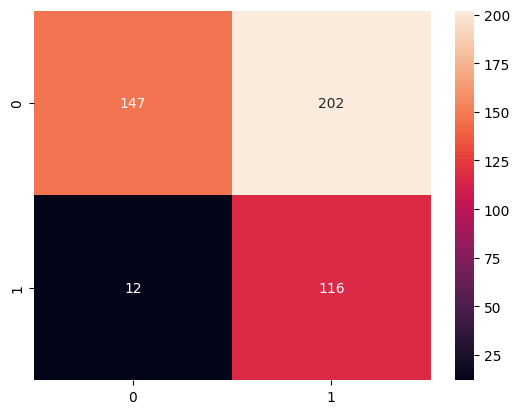

In [198]:
#plotar matriz de confusão para homens
cm_men_75 = confusion_matrix(df_test_male['EVOLUCAO'], y_pred_male)
sns.heatmap(cm_men_75, annot=True, fmt='d')
plt.show()

In [199]:
recall_score_female = recall_score(df_test_female['EVOLUCAO'], y_pred_female)
precision_score_female = precision_score(df_test_female['EVOLUCAO'], y_pred_female)
false_positives_fem = cm_fem_75[0][1] / (cm_fem_75[0][0] + cm_fem_75[0][1])
positive_predictions_fem = (cm_fem_75[0][1] + cm_fem_75[1][1]) / cm_fem_75.sum()


precision_score_male = precision_score(df_test_male['EVOLUCAO'], y_pred_male)
recall_score_male = recall_score(df_test_male['EVOLUCAO'], y_pred_male)
false_positives_fem = cm_men_75[0][1] / (cm_men_75[0][0] + cm_men_75[0][1])
positive_predictions_men = (cm_men_75[0][1] + cm_men_75[1][1]) / cm_men_75.sum()

In [200]:
results_75 = pd.DataFrame()
results_75['grupo'] = ['mulheres', 'homens']
results_75['recall'] = [recall_score_female, recall_score_male]
results_75['precision'] = [precision_score_female, precision_score_male]
results_75['taxa de falsos positivos'] = [false_positives_fem, false_positives_men]
results_75['predicoes positivas'] = [positive_predictions_fem, positive_predictions_men]

In [201]:
results_75

,grupo,recall,precision,taxa de falsos positivos,predicoes positivas
0,mulheres,0.884615,0.270588,0.578797,0.566667
1,homens,0.906250,0.364780,0.518625,0.666667


## Over/Under Sampling 0.99

In [202]:
train_data["CS_SEXO"].value_counts()

,count
CS_SEXO,
1,756
0,239


In [203]:
# selecionar instâncias de mulheres
df_train_female = train_data[train_data['CS_SEXO'] == 0]

# aumentar dados de mulheres
oversample = SMOTE(sampling_strategy=0.99)
X_train, y_train = oversample.fit_resample(train_data.drop(['CS_SEXO'], axis=1), train_data['CS_SEXO'])

# copiar dados
X_train["CS_SEXO"] = y_train
over_train_data = X_train.copy()

In [204]:
over_train_data["CS_SEXO"].value_counts()

,count
CS_SEXO,
1,756
0,748


In [205]:
#definir classificadores
classifiers_1 = {
              'KNN': KNeighborsClassifier(),
              'Random Forest': RandomForestClassifier(),
              'Logistic Regression': LogisticRegression()
              }
#parâmetros para grid search
knn_params = {'n_neighbors': [1, 5, 10],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

lr_params = {'class_weight': ['balanced',
                              {0: 1, 1: 2},
                              {0: 1, 1: 3}]
             }

rf_params = {
             'n_estimators': [10,100,200],
             'max_depth': [10,50],
             'min_samples_split': [2,10,30]
             }


parameters =  {'KNN': knn_params,
               'Random Forest': rf_params,
               'Logistic Regression': lr_params
               }

In [206]:
clf_score = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall'])
models_01 = {
    'KNN': [],
    'Random Forest': [],
    'Logistic Regression': []
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for clf_name in classifiers_1.keys():
    clf = classifiers_1[clf_name]
    params = parameters[clf_name]
    fold_score = {}

    print(clf_name)
    for i, (train, test) in tqdm(enumerate(kf.split(over_train_data.drop('EVOLUCAO', axis=1), over_train_data['EVOLUCAO']))):

        grid = GridSearchCV(
                          estimator=clone(clf),
                          param_grid=params,
                          scoring={"balanced_accuracy":"balanced_accuracy",
                                   "precision":"precision",
                                   "recall":"recall",
                                   "f1":"f1"},
                          refit="f1",
                          cv=5,
                          )

        # dividir em treino e teste
        X_train, X_test = over_train_data.drop('EVOLUCAO', axis=1).iloc[train], over_train_data.drop('EVOLUCAO', axis=1).iloc[test]
        y_train, y_test = over_train_data['EVOLUCAO'].iloc[train], over_train_data['EVOLUCAO'].iloc[test]

        # balancear treino
        X_train, y_train = balance(X_train, y_train)

        # treinar
        best_model = grid.fit(X_train, y_train)

        # testar
        predictions = best_model.predict(X_test)

        # calcular métricas
        fold_score['model'] = f"{clf_name}_{i}"
        fold_score['accuracy'] = balanced_accuracy_score(y_test, predictions)
        fold_score['precision'] = precision_score(y_test, predictions)
        fold_score['recall'] = recall_score(y_test, predictions)
        fold_score['f1'] = f1_score(y_test, predictions)

        # salvar métricas
        fold_score = pd.DataFrame(fold_score, index=[0])
        clf_score = pd.concat([clf_score,fold_score], ignore_index=True)

        # salvar modelo
        models_01[clf_name].append(best_model)

KNN


0it [00:00, ?it/s]<ipython-input-206-515960144>:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clf_score = pd.concat([clf_score,fold_score], ignore_index=True)
5it [00:06,  1.33s/it]


Random Forest


5it [01:38, 19.72s/it]


Logistic Regression


5it [00:01,  2.57it/s]


In [207]:
# clf_score

In [208]:
over_test_data = test_data.copy()
#change columns order
over_test_data = over_test_data[over_train_data.columns]
# check
over_test_data.columns

Index(['NU_IDADE_N', 'CLI_FEBRE', 'CLI_MIALGI', 'CLI_CEFALE', 'CLI_PROST',
       'CLI_CONGES', 'CLI_VOMITO', 'CLI_DIARRE', 'CLI_ICTERI', 'CLI_RENAL',
       'CLI_RESPIR', 'CLI_CARDIA', 'CLI_MENING', 'EVOLUCAO',
       'regiao_Centro_Oeste', 'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul',
       'regiao_Nordeste', 'CS_SEXO'],
      dtype='object')

In [209]:
# é possível perceber que o melhor modelo foi Random_Fores[0], pois possui maior f1
best_model = models_01['Logistic Regression'][3]

predictions = best_model.predict(over_test_data.drop('EVOLUCAO', axis=1))

accuracy = balanced_accuracy_score(over_test_data['EVOLUCAO'], predictions)
precision = precision_score(over_test_data['EVOLUCAO'], predictions)
recall = recall_score(over_test_data['EVOLUCAO'], predictions)
f1 = f1_score(over_test_data['EVOLUCAO'], predictions)

all_models_results = pd.concat([
    all_models_results,
    pd.DataFrame({
        'model': ['Oversampling 0.99'],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1]
    })]
)

In [210]:
best_model.best_estimator_

LogisticRegression(class_weight={0: 1, 1: 3})

In [211]:
# escolhemos a coluna sexo pra medir o fairness

# selecionar instancias de mulheres
df_test_female = over_test_data[over_test_data['CS_SEXO'] == 0]

# selecionar instancias de homens
df_test_male = over_test_data[over_test_data['CS_SEXO'] == 1]

# testar modelo nas instancias femininas
y_pred_female = best_model.predict(df_test_female.drop(['EVOLUCAO'], axis=1))

# testar modelo nas instancias masculinas
y_pred_male = best_model.predict(df_test_male.drop(['EVOLUCAO'], axis=1))

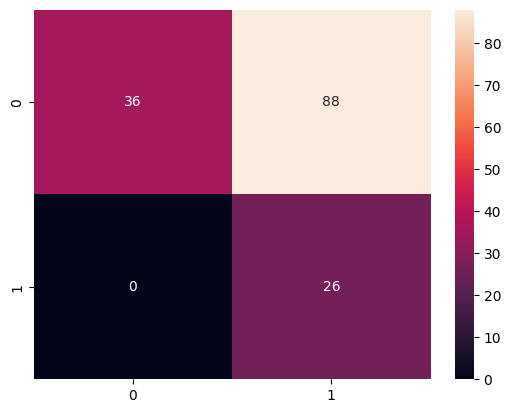

In [212]:
#plotar matriz de confusão para mulheres
cm_female_99 = confusion_matrix(df_test_female['EVOLUCAO'], y_pred_female)
sns.heatmap(cm_female_99, annot=True, fmt='d')
plt.show()

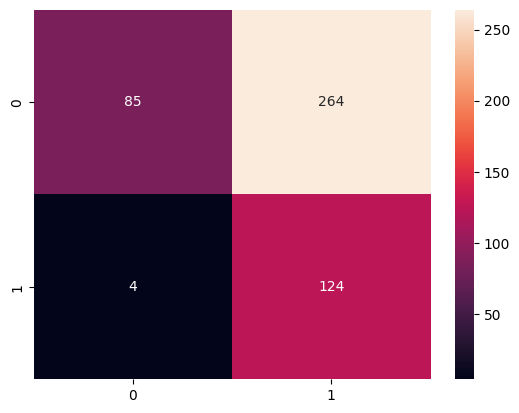

In [213]:
#plotar matriz de confusão para homens
cm_men_99 = confusion_matrix(df_test_male['EVOLUCAO'], y_pred_male)
sns.heatmap(cm_men_99, annot=True, fmt='d')
plt.show()

In [214]:
# checar recall para mulheres e recall para homens
recall_score_female = recall_score(df_test_female['EVOLUCAO'], y_pred_female)
precision_score_female = precision_score(df_test_female['EVOLUCAO'], y_pred_female)
false_positives_fem = cm_female_99[0][1] / (cm_female_99[0][0] + cm_female_99[0][1])
positive_predictions_fem = (cm_female_99[0][1] + cm_female_99[1][1]) / cm_female_99.sum()

precision_score_male = precision_score(df_test_male['EVOLUCAO'], y_pred_male)
recall_score_male = recall_score(df_test_male['EVOLUCAO'], y_pred_male)
false_positives_men = cm_men_99[0][1] / (cm_men_99[0][0] + cm_men_99[0][1])
positive_predictions_men = (cm_men_99[0][1] + cm_men_99[1][1]) / cm_men_99.sum()

In [215]:
results_99 = pd.DataFrame()
results_99['grupo'] = ['mulheres', 'homens']
results_99['recall'] = [recall_score_female, recall_score_male]
results_99['precision'] = [precision_score_female, precision_score_male]
results_99['taxa de falsos positivos'] = [false_positives_fem, false_positives_men]
results_99['predicoes positivas'] = [positive_predictions_fem, positive_predictions_men]

In [216]:
results_99

,grupo,recall,precision,taxa de falsos positivos,predicoes positivas
0,mulheres,1.00000,0.228070,0.709677,0.760000
1,homens,0.96875,0.319588,0.756447,0.813417


# Resultados

In [217]:
all_models_results

,model,accuracy,precision,recall,f1
0,Antes do Oversampling,0.700846,0.390093,0.818182,0.528302
0,Oversampling 0.5,0.685895,0.357513,0.896104,0.511111
0,Oversampling 0.75,0.672229,0.344913,0.902597,0.499102
0,Oversampling 0.99,0.614920,0.298805,0.974026,0.457317


In [223]:
columns = ['taxa de falsos positivos', 'precision', 'recall', 'predicoes positivas']
results_pre_fairness = results_pre_fairness[columns]
results_05 = results_05[columns]
results_75 = results_75[columns]
results_99 = results_99[columns]

In [224]:
results_pre_fairness

,taxa de falsos positivos,precision,recall,predicoes positivas
0,0.403226,0.295775,0.807692,0.473333
1,0.421203,0.416667,0.820312,0.528302


In [225]:
results_05

,taxa de falsos positivos,precision,recall,predicoes positivas
0,0.540323,0.263736,0.923077,0.606667
1,0.518625,0.386441,0.890625,0.618449


In [226]:
results_75

,taxa de falsos positivos,precision,recall,predicoes positivas
0,0.578797,0.270588,0.884615,0.566667
1,0.518625,0.364780,0.906250,0.666667


In [227]:
results_99

,taxa de falsos positivos,precision,recall,predicoes positivas
0,0.709677,0.228070,1.00000,0.760000
1,0.756447,0.319588,0.96875,0.813417
